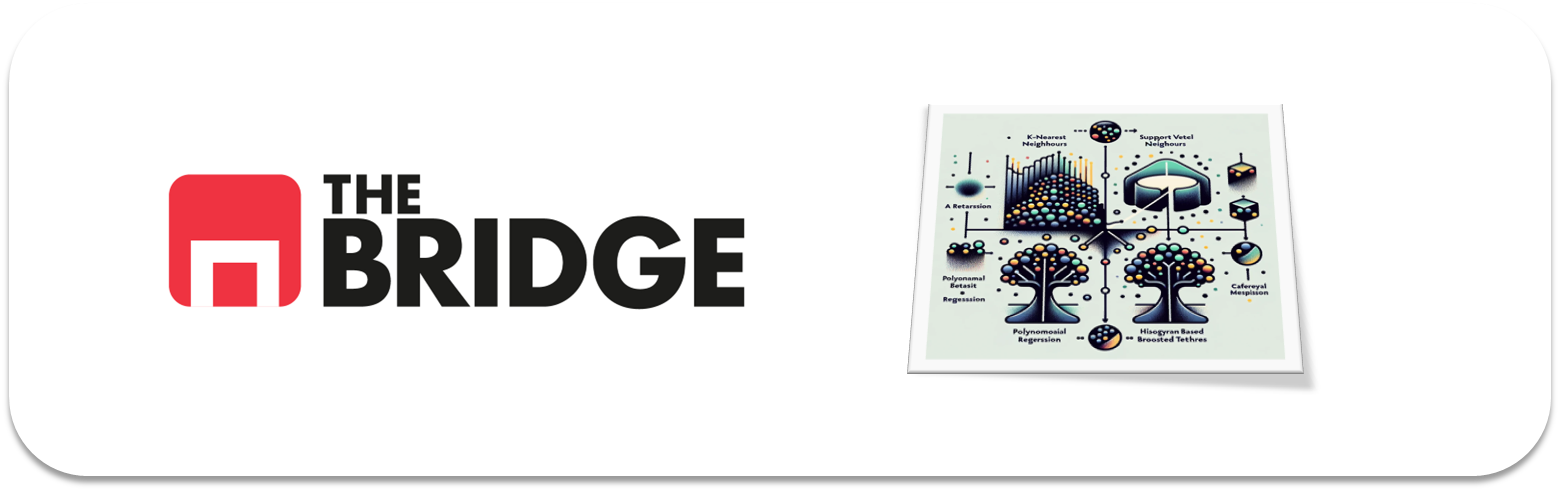

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from xgboost import XGBClassifier

import datascience as ds
import machinelearningtools as ml
import vizdatatools as viz

# 1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro `objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años`. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

## 1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
df_credit = pd.read_csv('./data/credit_npo.csv')
df_credit.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


Este dataset proviene del *Give Me Some Credit* dataset de Kaggle, el cual está diseñado para predecir si una persona tendrá dificultades financieras en los próximos dos años. La variable objetivo es *SeriousDlqin2yrs*, que indica si un cliente experimentó un atraso de pago de más de 90 días en los últimos dos años. Aquí tienes una descripción de las variables:

- SeriousDlqin2yrs: Variable binaria (0 o 1) que indica si el cliente experimentó un atraso de 90 días o más en los últimos dos años (target).
- RevolvingUtilizationOfUnsecuredLines: Relación entre el saldo total de crédito sin garantía (por ejemplo, tarjetas de crédito) y el límite de crédito disponible.
- age: Edad del cliente.
- NumberOfTime30-59DaysPastDueNotWorse: Número de veces que el cliente estuvo atrasado entre 30 y 59 días en los pagos, sin que la situación fuera peor.
- DebtRatio: Relación entre la deuda mensual y el ingreso mensual.
- MonthlyIncome: Ingreso mensual del cliente.
- NumberOfOpenCreditLinesAndLoans: Número de líneas de crédito y préstamos abiertos (incluye tarjetas de crédito, préstamos hipotecarios, etc.).
- NumberOfTimes90DaysLate: Número de veces que el cliente ha estado atrasado más de 90 días en los pagos.
- NumberRealEstateLoansOrLines: Número de préstamos hipotecarios o líneas de crédito para bienes raíces.
- NumberOfTime60-89DaysPastDueNotWorse: Número de veces que el cliente estuvo atrasado entre 60 y 89 días en los pagos, sin que la situación fuera peor.
- NumberOfDependents: Número de dependientes declarados por el cliente (por ejemplo, hijos u otras personas dependientes económicamente).

Este dataset es comúnmente utilizado en modelos de predicción de riesgos crediticios para evaluar la probabilidad de incumplimiento de un cliente financiero.

In [3]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

> Puedo ver que el hay elementos missing. Como tengo suficientes datos voy a eliminar directamente los valores faltantes, y no invertir tiempo en estimarlos. Además NO podría hacerlo en la parte de test.

> Previamente ya me he encargado de comprobar que no me he modificado la distribución original del target al eliminar filas. Conservo el mismo porcentaje de casos de éxito y fracaso.

In [4]:
# Eliminar missings
df_credit.dropna(inplace=True)

# Para evitar problemas con el OneHot Enconder
df_credit['NumberOfDependents'] = df_credit['NumberOfDependents'].astype('int64')

df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  int64  
dtypes: float64(3), int64

In [5]:

ds.get_cardinality(df_credit, threshold_categorical=11, threshold_continuous=30)

pandas.DataFrame shape:  (11816, 11)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
SeriousDlqin2yrs,2,0.016926,0,0.0,int64,Binary
RevolvingUtilizationOfUnsecuredLines,10314,87.288422,0,0.0,float64,Numeric - Continuous
age,78,0.660122,0,0.0,int64,Numeric - Discrete
NumberOfTime30-59DaysPastDueNotWorse,10,0.084631,0,0.0,int64,Categoric
DebtRatio,11472,97.088693,0,0.0,float64,Numeric - Continuous
MonthlyIncome,4167,35.265741,0,0.0,float64,Numeric - Continuous
NumberOfOpenCreditLinesAndLoans,43,0.363913,0,0.0,int64,Numeric - Discrete
NumberOfTimes90DaysLate,13,0.11002,0,0.0,int64,Numeric - Discrete
NumberRealEstateLoansOrLines,16,0.13541,0,0.0,int64,Numeric - Discrete
NumberOfTime60-89DaysPastDueNotWorse,8,0.067705,0,0.0,int64,Categoric


De momento, y tras emplear la función `get_cardinality()`, coincido con la clasificación propuesta de numéricas y categóricas.

## 1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Es un problema de clasificación binaria, donde el *target* es: `SeriousDlqin2yrs`.

## 1.3
Pinta la distribución de frecuencias del target y coméntala

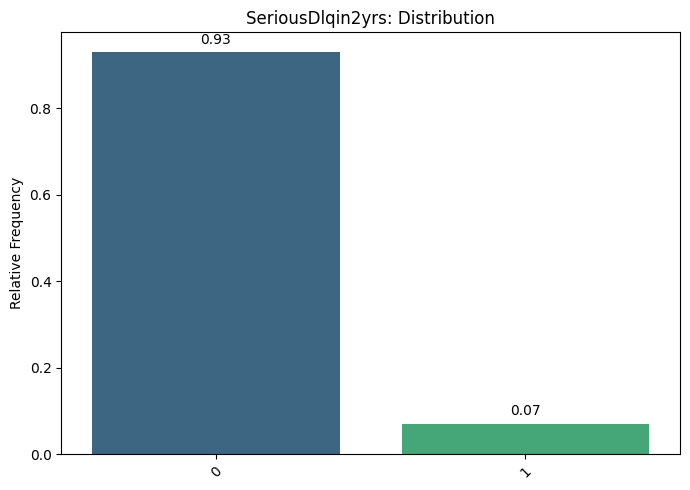

SeriousDlqin2yrs
0    10986
1      830
Name: count, dtype: int64

In [6]:
viz.plot_multiple_categorical_distributions(df_credit, ['SeriousDlqin2yrs'], relative=True);

df_credit['SeriousDlqin2yrs'].value_counts()

Es este problema de clasificación hay un **desbalanceo** en el target bastante importante.

# 2. Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). 

Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este - después de hablar con el negocio - es el `recall medio`, para tener un compromiso entre las dos clases). 

Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

# 3. Separar train y test

In [7]:
target = 'SeriousDlqin2yrs'

train_set, test_set = train_test_split(df_credit, test_size=.2, random_state=42)

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]
X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

# Proporciones similares en train y test de la variable target
display(train_set[target].value_counts(True))
display(test_set[target].value_counts(True))

SeriousDlqin2yrs
0    0.929856
1    0.070144
Name: proportion, dtype: float64

SeriousDlqin2yrs
0    0.929357
1    0.070643
Name: proportion, dtype: float64

# 4. Mini-EDA

In [8]:
# Variables categóricas (a mi criterio)
cat_features = ['NumberOfTime30-59DaysPastDueNotWorse', 
                'NumberOfTime60-89DaysPastDueNotWorse', 
                'NumberOfDependents'
]

# Variables numéricas
num_features = [col for col in X_train.columns if col not in cat_features]

print('Categóricas:', cat_features)
print('Numéricas:', num_features)

Categóricas: ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Numéricas: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines']


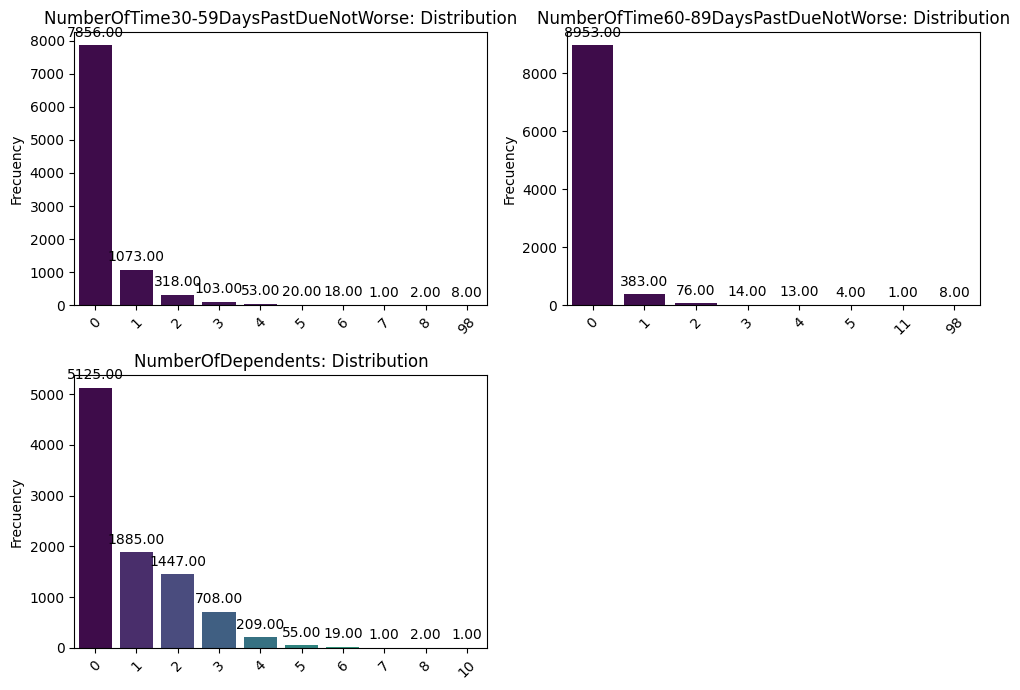

In [9]:
# Análisis univariante de variables categóricas con el target
viz.plot_multiple_categorical_distributions(X_train, cat_features, relative=False)

> Son distribuciones categóricas muy desiguales, pero no quiero hacer más bins porque probablemente sea importante para relacionarlo con el *target*.

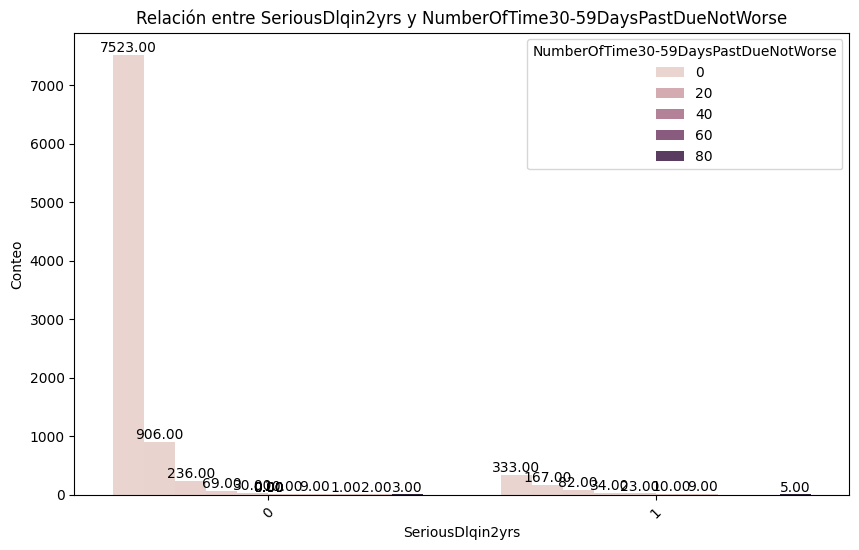

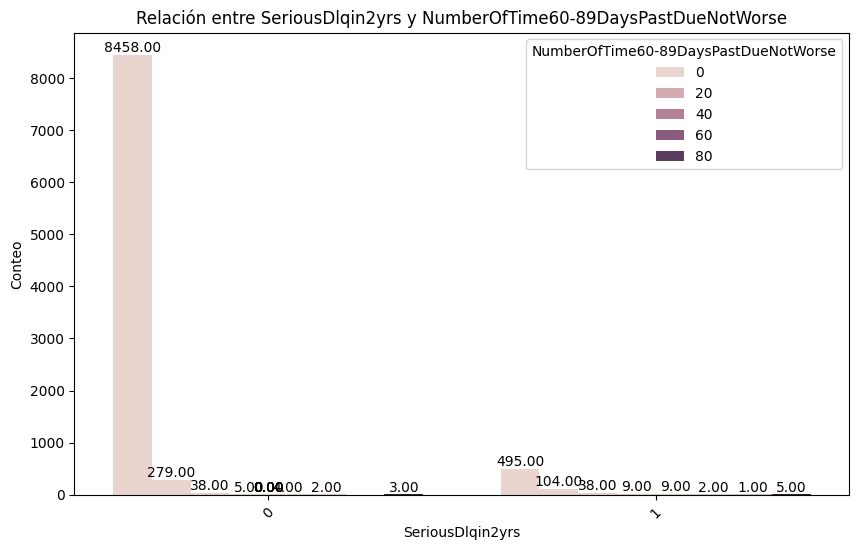

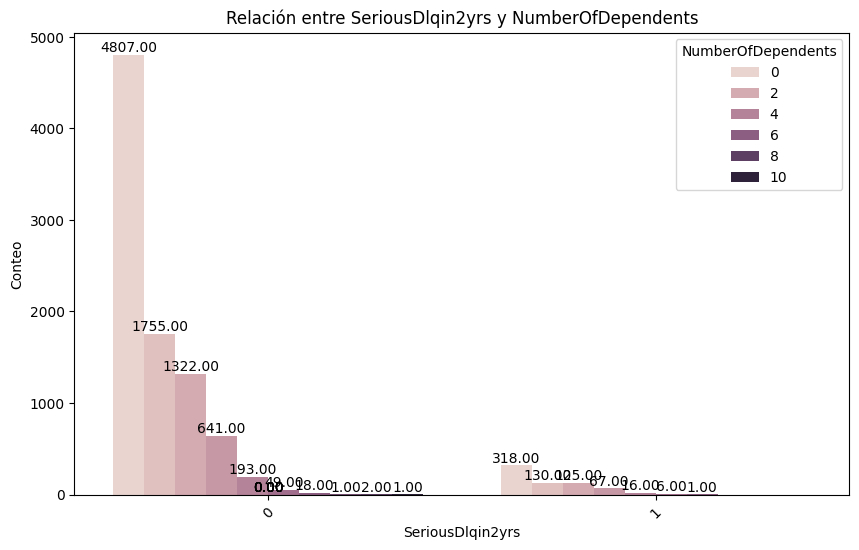

In [10]:
# Análisis bivariante de variables categóricas con el target
for cat_col in cat_features:
    viz.plot_categorical_relationship(train_set, target, cat_col, relative_freq=False)


> La que menos significancia creo ver con el target es "NumberOfDependents", pero de momento no voy a eliminar ninguna.

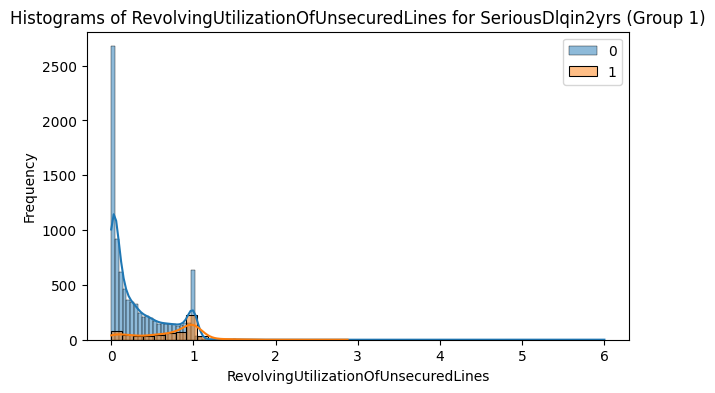

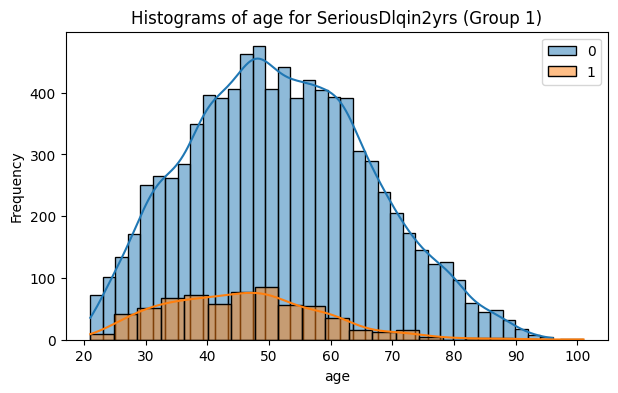

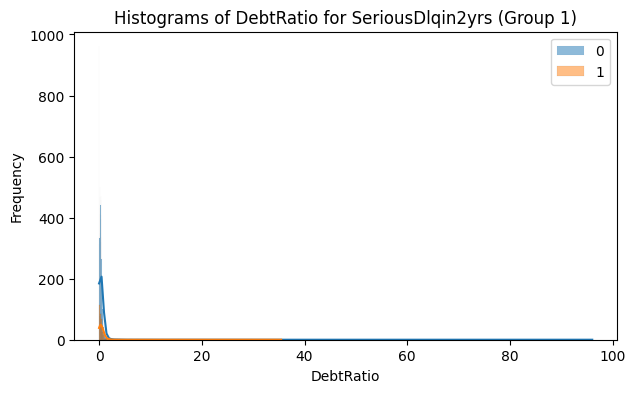

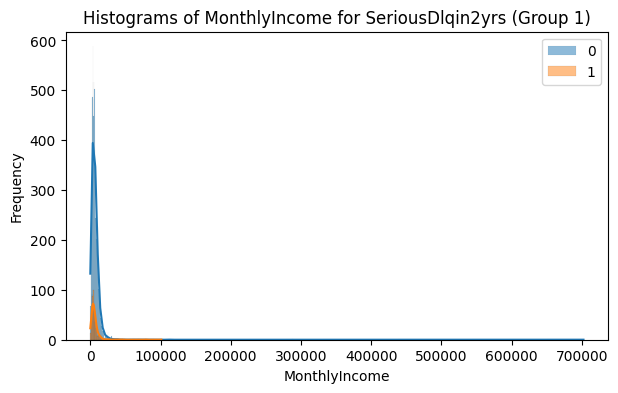

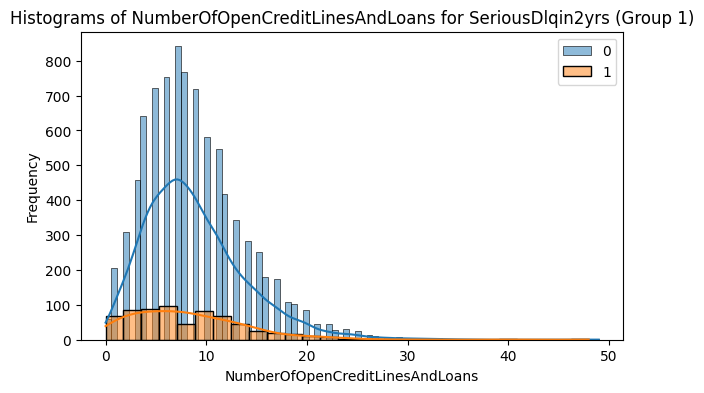

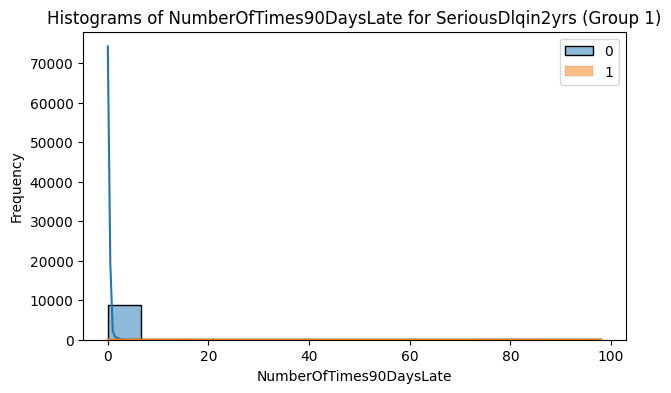

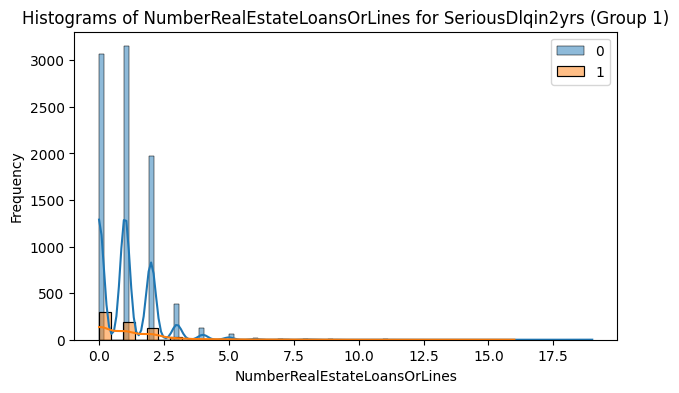

In [11]:
# Análisis bivariante de las columnas numéricas con la categórica (target)
for num_col in num_features:
    viz.plot_histograms_grouped(train_set, target, num_col)

> "RevolvingUtilizationOfUnsecuredLines" y "age" parecen los mejores clasificadores (sus histogramas están más separados para 0 y 1), pero me voy a quedar todas las features igualmente.

# 5. Tratamiento de features categóricas

Se que no es conveniente convertir tantas categorias a numéricas porque el modelo me va a quedar muy complejo, pero quiero probar qué pasa. Y para ello voy a usar un One-Hot Encoder

In [12]:
# Inicializamos el OneHotEncoder con sparse=False para obtener un array denso, y drop='first' para evitar colinealidad
onehotencoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Ajustamos el encoder usando X_train y luego transformamos tanto X_train como X_test
X_train_encoded = pd.DataFrame(onehotencoder.fit_transform(X_train[cat_features]), 
                                  columns=onehotencoder.get_feature_names_out(cat_features)
)
X_test_encoded = pd.DataFrame(onehotencoder.transform(X_test[cat_features]),
                                 columns=onehotencoder.get_feature_names_out(cat_features)
)

# Reindexamos los DataFrames para asegurarnos de que coincidan con los índices de X_train y X_test
X_train_encoded.index = X_train.index
X_test_encoded.index = X_test.index

# Concatenamos las nuevas columnas codificadas con las columnas originales no categóricas
X_train = pd.concat([X_train.drop(columns=cat_features), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=cat_features), X_test_encoded], axis=1)

# Mostrar las primeras filas del nuevo X_train con las columnas categóricas codificadas
display(X_train.head())


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime30-59DaysPastDueNotWorse_1,NumberOfTime30-59DaysPastDueNotWorse_2,NumberOfTime30-59DaysPastDueNotWorse_3,...,NumberOfTime60-89DaysPastDueNotWorse_98,NumberOfDependents_1,NumberOfDependents_2,NumberOfDependents_3,NumberOfDependents_4,NumberOfDependents_5,NumberOfDependents_6,NumberOfDependents_7,NumberOfDependents_8,NumberOfDependents_10
11145,0.391240,68,2.693124,2166.0,13,0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.906540,59,0.325227,6496.0,7,0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5428,0.933223,52,0.372442,8258.0,3,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12130,0.857859,50,0.511098,5225.0,9,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.000000,61,0.414167,5166.0,5,0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6. Tratamiento de features numéricas.

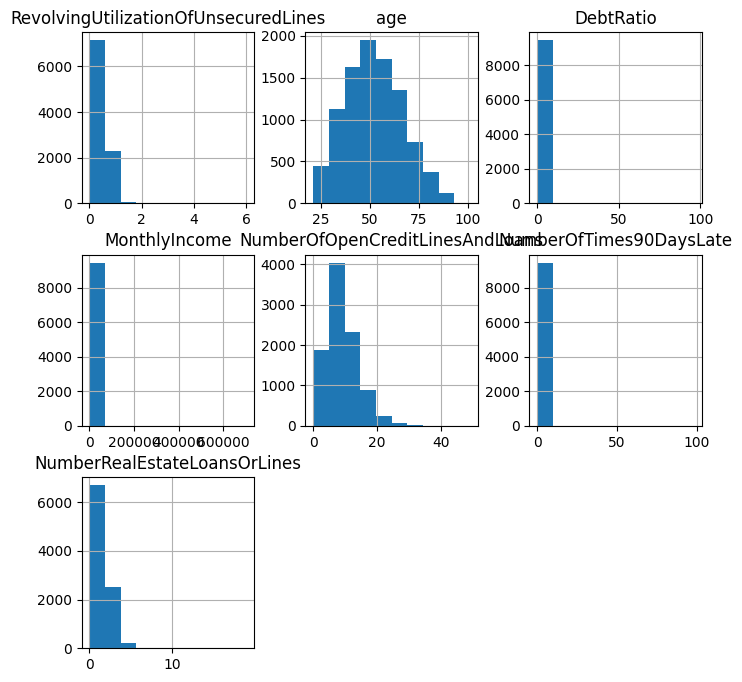

In [13]:
# X_train puro con su distribución
X_train[num_features].hist(figsize=(8, 8));

A excepción de "age" todas las demás no tienen distribuciones normales, y por eso voy a aplicar el logaritmo, de forma que sus histogramas mejoren.

> NOTA: A los árboles, las transformacines lineales o no lineales (como el escalado, normalización, logaritmo, raíz cuadrada...) no les afecta para el rendimiento, pero lo voy a aplicar igualmente porque para la Regresión Logística sí es importante.

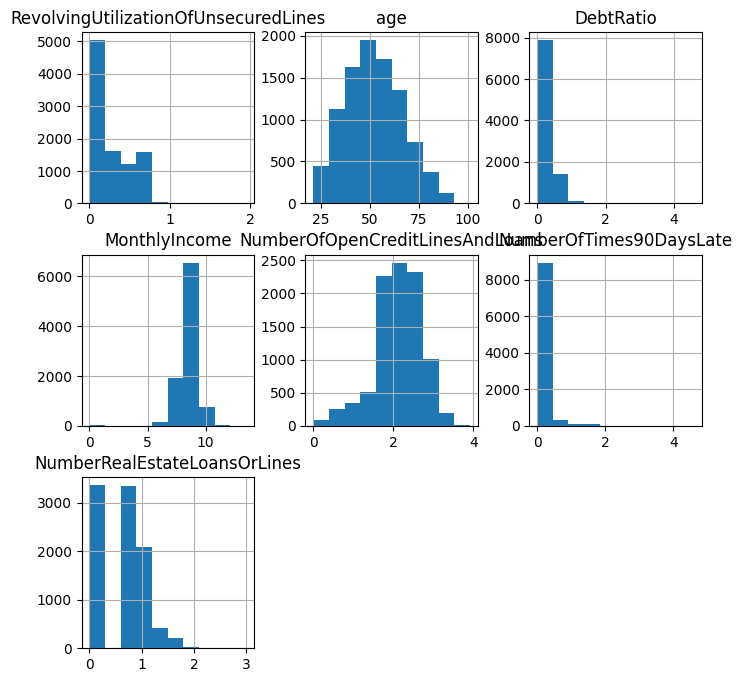

In [14]:
# Aplicar el logaritmo de manera segura
def safe_log(column):
    """
    Aplicar el logaritmo de manera segura, para evitar hacer log(0) o de números negativos.
    """
    # Desplazar los valores si hay alguno <= 0
    min_val = column.min()
    if min_val <= 0:
        column = column - min_val + 1
    return np.log(column)


for column in num_features:
    if column != 'age':
        X_train[column] = safe_log(X_train[column])
        X_test[column] = safe_log(X_test[column])
        
# Nueva varianza tras la aplicación del logaritmo
X_train[num_features].hist(figsize=(8, 8));
    

Bueno... hemos mejorado algunas pero otras se han quedado parecido.

A los árboles no les importa, pero para el modelo de regresión logística es interesante que los valores estén escalados o normalizados. Voy a normalizar ya que sobre las variables categóricas he hecho un One-Hot Encoder. Así todo valdrá entre 0 y 1.

In [15]:
scaler = MinMaxScaler()

# Ajustamos el scaler con los datos de entrenamiento y transformamos tanto el train como el test
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_features]), 
                                 columns=num_features, 
                                 index=X_train.index
)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_features]), 
                                columns=num_features, 
                                index=X_test.index
)

# Concatenamos las columnas escaladas con el resto de las columnas (ya transformadas por OneHotEncoder)
X_train = pd.concat([X_train_scaled, X_train.drop(columns=num_features)], axis=1)
X_test = pd.concat([X_test_scaled, X_test.drop(columns=num_features)], axis=1)

# Mostrar las primeras filas del nuevo X_train con las columnas numéricas escaladas
display(X_train.head())
display(X_train.describe())
display(X_test.describe())

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime30-59DaysPastDueNotWorse_1,NumberOfTime30-59DaysPastDueNotWorse_2,NumberOfTime30-59DaysPastDueNotWorse_3,...,NumberOfTime60-89DaysPastDueNotWorse_98,NumberOfDependents_1,NumberOfDependents_2,NumberOfDependents_3,NumberOfDependents_4,NumberOfDependents_5,NumberOfDependents_6,NumberOfDependents_7,NumberOfDependents_8,NumberOfDependents_10
11145,0.169687,0.5875,0.285586,0.570559,0.674602,0.0,0.366726,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,0.331613,0.4750,0.061552,0.652120,0.531551,0.0,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5428,0.338756,0.3875,0.069205,0.669944,0.354368,0.0,0.231378,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12130,0.318321,0.3625,0.090243,0.635949,0.588592,0.0,0.231378,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.000000,0.5000,0.075751,0.635106,0.458014,0.0,0.231378,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime30-59DaysPastDueNotWorse_1,NumberOfTime30-59DaysPastDueNotWorse_2,NumberOfTime30-59DaysPastDueNotWorse_3,...,NumberOfTime60-89DaysPastDueNotWorse_98,NumberOfDependents_1,NumberOfDependents_2,NumberOfDependents_3,NumberOfDependents_4,NumberOfDependents_5,NumberOfDependents_6,NumberOfDependents_7,NumberOfDependents_8,NumberOfDependents_10
count,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,...,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000
mean,0.131816,0.381144,0.065056,0.633804,0.545616,0.012225,0.199005,0.113521,0.033644,0.010897,...,0.000846,0.199429,0.153089,0.074905,0.022112,0.005819,0.002010,0.000106,0.000212,0.000106
std,0.127718,0.181241,0.062855,0.064716,0.147662,0.057882,0.167424,0.317245,0.180320,0.103825,...,0.029082,0.399592,0.360093,0.263252,0.147055,0.076063,0.044792,0.010286,0.014546,0.010286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017614,0.250000,0.029828,0.605467,0.458014,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.084714,0.375000,0.056941,0.638957,0.561659,0.000000,0.231378,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.237514,0.512500,0.085384,0.670321,0.635197,0.000000,0.366726,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime30-59DaysPastDueNotWorse_1,NumberOfTime30-59DaysPastDueNotWorse_2,NumberOfTime30-59DaysPastDueNotWorse_3,...,NumberOfTime60-89DaysPastDueNotWorse_98,NumberOfDependents_1,NumberOfDependents_2,NumberOfDependents_3,NumberOfDependents_4,NumberOfDependents_5,NumberOfDependents_6,NumberOfDependents_7,NumberOfDependents_8,NumberOfDependents_10
count,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,...,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.000000,2364.0,2364.0,2364.0
mean,0.132115,0.378405,0.063741,0.633667,0.540613,0.011578,0.194654,0.118866,0.033418,0.010152,...,0.000846,0.204738,0.154822,0.073181,0.017766,0.002538,0.002115,0.0,0.0,0.0
std,0.129218,0.182321,0.069373,0.070270,0.148273,0.057322,0.168689,0.323700,0.179763,0.100267,...,0.029080,0.403595,0.361812,0.260489,0.132130,0.050326,0.045951,0.0,0.0,0.0
min,0.000000,0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.018036,0.237500,0.027556,0.606192,0.458014,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,0.084523,0.375000,0.054136,0.637161,0.561659,0.000000,0.231378,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,0.235413,0.512500,0.084870,0.670334,0.635197,0.000000,0.366726,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,0.949728,0.950000,0.989616,0.919441,0.967323,1.000000,0.829482,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0


# 7. Gestión del desbalanceo del target y entrenamiento de modelos sin optimización de hiperparámetros.

La técnica del UnderSampling (RandomUnderSampler) NO quiero usarla porque me quedaría con muy pocos datos. Solo voy a utilizar `Oversampling` con SMOTE, o ajustar el hiperparámetro `class_weight` de cada modelo.

Voy a probar cuatro estimadores de regresión para ambos casos:
- KNN
- Logistic Regression
- Random Forest
- XGBoost

Para comparar modelos voy a usar la validación cruzada, y después de "hablar" con negocio se nos ha indicado que la métrica que importa es el *recall medio*. Este es es el parámetro *scoring='balanced_accuracy'* de *sklearn.model_selection.cross_val_score*.

## 7.1 Aplicar SMOTE (Synthetic Minority Over-sampling Technique)

Primero amplio el dataset de train con datos sintéticos. SMOTE por dentro usa un KNN para crear las features de los sintéticos (y eso no tiene porque salir mejor).

In [16]:
# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

display(y_train.value_counts(True))
display(y_train_smote.value_counts(True))

SeriousDlqin2yrs
0    0.929856
1    0.070144
Name: proportion, dtype: float64

SeriousDlqin2yrs
0    0.5
1    0.5
Name: proportion, dtype: float64

In [17]:
### KNN. Sin ajustar hiperparámetros, sobre X_train_smote
knn_clf = KNeighborsClassifier()

# Validación cruzada con 5 folds
knn_mean_recall = np.mean(cross_val_score(knn_clf, X_train_smote, y_train_smote, cv=5, scoring='balanced_accuracy'))
print(f'Recall Medio (KNN): {knn_mean_recall}')


Recall Medio (KNN): 0.9023776825090343


In [18]:
### Logistic Regresion. Sin ajustar hiperparámetros, sobre X_train_smote
logreg_clf = LogisticRegression(max_iter=10_000, random_state=42)

# Validación cruzada con 5 folds
logreg_mean_recall = np.mean(cross_val_score(logreg_clf, X_train_smote, y_train_smote, cv=5, scoring='balanced_accuracy'))
print(f'Recall Medio (Logistic Regression): {logreg_mean_recall}')

Recall Medio (Logistic Regression): 0.7771659340211072


In [19]:
### Random Forest. Sin ajustar hiperparámetros, sobre X_train_smote
rf_clf = RandomForestClassifier(max_depth=5, random_state=42)

# Validación cruzada con 5 folds
rf_mean_recall = np.mean(cross_val_score(rf_clf, X_train_smote, y_train_smote, cv=5, scoring='balanced_accuracy'))
print(f'Recall Medio (Random Forest): {rf_mean_recall}')

Recall Medio (Random Forest): 0.7924127316510005


In [20]:
### XGBoost. Sin ajustar hiperparámetros, sobre X_train_smote
xgb_clf = XGBClassifier(max_depth=5, verbosity=0)

# Validación cruzada con 5 folds
xgb_mean_recall = np.mean(cross_val_score(xgb_clf, X_train_smote, y_train_smote, cv=5, scoring='balanced_accuracy'))
print(f'Recall Medio (XGBoost): {xgb_mean_recall}')

Recall Medio (XGBoost): 0.9407811303137846


> Se obtienen muy buenos resultados de recall medio para *XGBClassifier* y para *Random Forest*.

## 7.2 Hacer uso del argumento *class_weight* para compensar el desbalanceo del target, en aquellos modelos que lo permiten.

KNN no admite un argumento *class_weight*, sin embargo voy a entrenar con el set original igualmente para ver el resultado.

XGBClassifier tiene su propio argumento *scale_pos_weight* que hay que investigar en la documentación oficial. Lo aplicaré más abajo.

In [21]:
### KNN. Sin ajustar hiperparámetros, sobre X_train
knn_clf = KNeighborsClassifier()

# Validación cruzada con 5 folds
knn_mean_recall = np.mean(cross_val_score(knn_clf, X_train, y_train, cv=5, scoring='balanced_accuracy'))
print(f'Recall Medio (KNN): {knn_mean_recall}')

Recall Medio (KNN): 0.5458262022041394


> El resultado, como era de esperar, en esta ocasión es mucho peor para KNN porque el target está muy desbalanceado.

In [22]:
### Logistic Regresion. Sin ajustar hiperparámetros, sobre X_train
logreg_clf = LogisticRegression(max_iter=10_000, class_weight='balanced', random_state=42)

# Validación cruzada con 5 folds
logreg_mean_recall = np.mean(cross_val_score(logreg_clf, X_train, y_train, cv=5, scoring='balanced_accuracy'))
print(f'Recall Medio (Logistic Regression): {logreg_mean_recall}')

Recall Medio (Logistic Regression): 0.7670651596325943


> Un resultado bastante similar a cuando he usado SMOTE.

In [23]:
### Random Forest. Sin ajustar hiperparámetros, sobre X_train
rf_clf = RandomForestClassifier(max_depth=5, class_weight='balanced', random_state=42)

# Validación cruzada con 5 folds
rf_mean_recall = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='balanced_accuracy'))
print(f'Recall Medio (Random Forest): {rf_mean_recall}')

Recall Medio (Random Forest): 0.7533922947671761


> Ha empeorado un poco pero está bastante próximo a cuando he usado el SMOTE. Con un ajuste de hiperparámetros seguro que se puede mejorar.

In [24]:
### XGBoost. Sin ajustar hiperparámetros, sobre X_train

# Calculamos scale_pos_weight
num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()
scale_pos_weight = num_negatives / num_positives

# Definir y entrenar el XGBClassifier con el parámetro scale_pos_weight
xgb_clf = XGBClassifier(max_depth=5, scale_pos_weight=scale_pos_weight, verbosity=0)

# Validación cruzada con 5 folds
xgb_mean_recall = np.mean(cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='balanced_accuracy'))
print(f'Recall Medio (XGBoost): {xgb_mean_recall}')


Recall Medio (XGBoost): 0.6698354542485652


> El resultado, a pesar de haber empleado scale_pos_weight ha empeorado bastante.

# 8. Elección de modelo y ajuste hiperparámetros.

Los mejores resultados se han obtenido al crear nuevos datos sintéticos con `SMOTE`, y de los 4 modelos evaluados los que mejor métrica de recall medio han tenido con `XGBoost` y `KNeighborsClassifier`. Voy a ajustar los hiperparámetros de ambos sobre este train_smote.

In [25]:
# Definir el modelo XGBoostClassifier
xgb_clf = XGBClassifier()

# Definir los hiperparámetros a probar
xgb_params_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'colsample_bylevel': [0.7, 0.8, 1.0]
}

# Inicializamos GridSearchCV con 5 folds de validación cruzada
xgb_grid = GridSearchCV(xgb_clf,
                        xgb_params_grid, 
                        cv=5, 
                        scoring='balanced_accuracy', 
                        verbose=1, 
                        n_jobs=-1
)

# Ajustamos los hiperparámetros usando los datos de entrenamiento SMOTE
xgb_grid.fit(X_train_smote, y_train_smote)

# Mostrar los mejores hiperparámetros
print(f"Mejores hiperparámetros para XGBoost: {xgb_grid.best_params_}")

# Mostrar mejor score
print(f"Mejor score para XGBoost: {xgb_grid.best_score_}")

# Evaluamos en el conjunto de prueba
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)

# Imprimir el reporte de clasificación para el modelo XGBoost
print("Reporte de clasificación para XGBoost:")
print(classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejores hiperparámetros para XGBoost: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Mejor score para XGBoost: 0.9505658173417171
Reporte de clasificación para XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2197
           1       0.39      0.22      0.28       167

    accuracy                           0.92      2364
   macro avg       0.67      0.60      0.62      2364
weighted avg       0.90      0.92      0.91      2364



AUC: 0.78


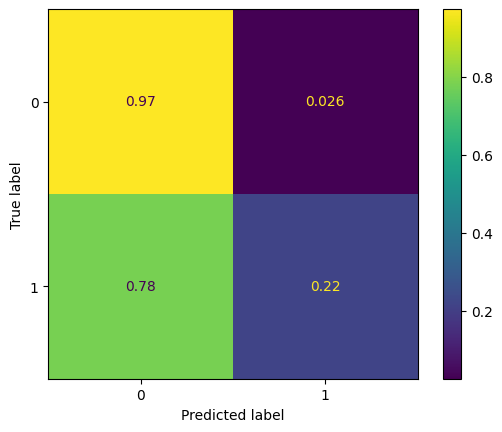

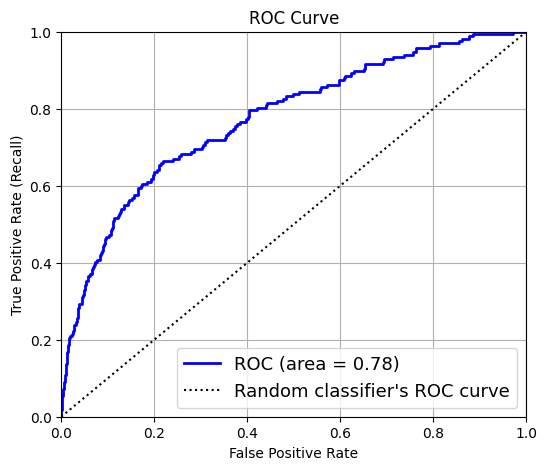

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, normalize='true')
ml.plot_roc_curve(xgb_grid.best_estimator_, X_test, y_test)

In [28]:
# Definir el modelo KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# Definir los hiperparámetros a probar
knn_params_grid = {
    'n_neighbors': range(1, 21),  # Probar entre 1 y 20 vecinos
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Inicializamos GridSearchCV con 5 folds de validación cruzada
knn_grid = GridSearchCV(knn_clf, 
                        knn_params_grid, 
                        cv=5, 
                        scoring='balanced_accuracy', 
                        verbose=1, 
                        n_jobs=-1
)

# Ajustamos los hiperparámetros usando los datos de entrenamiento
knn_grid.fit(X_train_smote, y_train_smote)

# Mostrar los mejores hiperparámetros
print(f"Mejores hiperparámetros para KNN: {knn_grid.best_params_}")

# Mostrar mejor score
print(f"Mejor score para KNN: {knn_grid.best_score_}")

# Evaluamos en el conjunto de prueba
y_pred_knn = knn_grid.best_estimator_.predict(X_test)

# Imprimir el reporte de clasificación para el modelo KNeighborsClassifier
print("Reporte de clasificación para KNeighborsClassifier:")
print(classification_report(y_test, y_pred_knn))


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Mejores hiperparámetros para KNN: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Mejor score para KNN: 0.937819921354724
Reporte de clasificación para KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2197
           1       0.21      0.34      0.26       167

    accuracy                           0.87      2364
   macro avg       0.58      0.62      0.59      2364
weighted avg       0.90      0.87      0.88      2364



AUC: 0.62


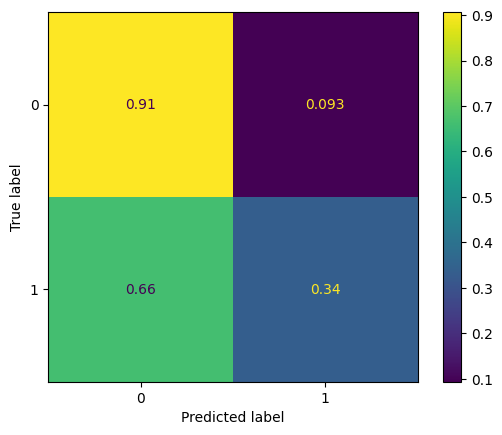

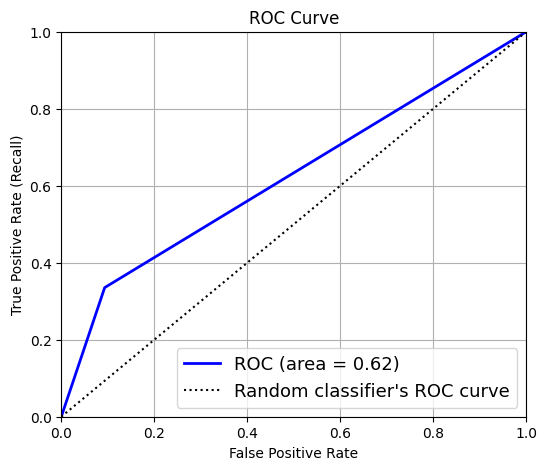

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, normalize='true')
ml.plot_roc_curve(knn_grid.best_estimator_, X_test, y_test)

Estos resultados están FATAL, porque puede que sean buenos prediciendo 0's, pero para la predicción de 1's acierta muy poco.

También veo una incongruencia entre el 'balanced_accuracy', que esperaba que fuera la media de los recall, y la verdadera media de los recall que puedo calcular a mano desde los classification_report().

Aún con todo y si me creo que los resultados que he obtenido:

- XGBoost tiene un accuracy superior (92% frente al 87% de KNN), lo cual indica que maneja bien la clase mayoritaria (0). Sin embargo, su recall para la clase 1 es bajo, solo el 22%, lo que significa que está fallando en capturar muchos de los ejemplos de la clase minoritaria.
- KNN tiene un mejor recall para la clase minoritaria (1) en comparación con XGBoost, con un recall de 34% frente a 22% en XGBoost. Sin embargo, KNN sacrifica rendimiento en la clase mayoritaria, lo que afecta su accuracy global.
- XGBoost ofrece un mejor rendimiento en general, pero como interesa capturar más ejemplos de la clase 1 (aún sacrificando algo de precisión), KNN podría ser más adecuado.
